![CC-BY-SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)


This notebook was created by [Bernardo Freitas Paulo da Costa](http://www.im.ufrj.br/bernardofpc),
and is licensed under Creative Commons BY-SA.

Antes de enviar este Teste, verifique que tudo está funcionando como esperado.
Por exemplo, **rode o código inteiro, do zero**.
Para isso, vá no menu, escolha _Kernel_, depois _Restart & Run All_.

Verifique, também, que você respondeu todas as questões:
* as questões de código têm `YOUR CODE HERE` (e você pode apagar o `raise NotImplemented` ao incluir sua resposta)
* as questões discursivas têm "YOUR ANSWER HERE".

---

# Integrando funções menos regulares

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def midpoint(f, a, b, n=1000):
  pts, h = np.linspace(a, b, num=n, endpoint=False, retstep=True)
  m = pts + h/2
  return (np.sum(f(m))* h)

def simpson(f, a, b, n=1000):
  pts, h = np.linspace(a, b, num=n, endpoint=False, retstep=True)
  m = pts + h/2
  return ( 4 * np.sum(f(m)) + 2 * np.sum(f(pts)) + (f(b) - f(a)) ) *h/6 

In [3]:
def f(x):
    return np.abs(np.sin(x))

## Questão 1: Primitiva

Dê uma primitiva analítica de $f$.

Dica: use a função `np.divmod` (versão vetorizada da `divmod` do python).

In [4]:
def F(x):
    """Primitiva de |sin(x)|, exata até a precisão do computador."""
    q, r = np.divmod(x,np.pi)
    return ((2 * q) - np.cos(r) + 1)

In [5]:
assert np.isclose(F(10+0.1), F(10) + 0.1 * f(10), atol=1e-2)

In [6]:
assert np.isclose(F(2+0.01), F(2) + 0.01 * f(2), atol=1e-4)

Explique as tolerâncias dos testes acima.

No primeiro teste, temos uma comparação com tolerância de $10^{-2}$ da integral exata no intervalo $[0,10.1]$ com a integral do intervalo $[0,10]$ somada com um retângulo de base $h=0.1$ e altura $f(10)$. Enquanto no segundo teste, temos uma comparação com tolerância de $10^{-4}$ da integral exata no intervalo $[0,2.01]$ com a integral do intervalo $[0,2]$ somada com um retângulo de base $h=0.01$ e altura $f(2)$.

Essas tolerâncias são baseadas no quadrado da base $h$ do retângulo, ou seja, para um dado passo $h$, o erro no método do retângulo nesse intervalo está em uma tolerância na ordem de $h^2$. Sendo assim, as tolerâncias apresentadas nos testes acima, consideram o erro no método do retangulo da ordem de $h^2$ em cada retângulo aplicado no método.

In [7]:
ts = np.linspace(0,10, num=200)
Fts = F(ts)
assert np.all(Fts[1:] > Fts[:-1])

## Questão 2: Erros

Faça um gráfico dos erros de integração de $f$
pelos métodos do ponto médio e Simpson, no intervalo $[0,3]$

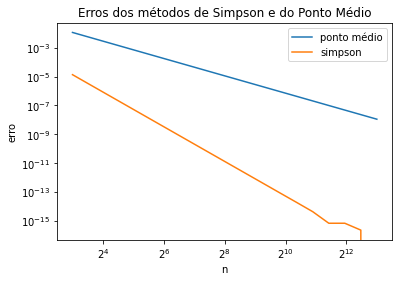

In [8]:
a, b = 0, 3
exact = F(b) - F(a)
ns = np.logspace(3,13, num=20, dtype=int, base=2)
err_m = []
err_s = []

for n in ns:
  err_m.append(abs(exact - midpoint(f, a, b, n) ))
  err_s.append(abs(exact - simpson(f, a, b, n) ))

ax = plt.gca()
ax.set_title("Erros dos métodos de Simpson e do Ponto Médio")
ax.loglog( ns, err_m, label="ponto médio")
ax.loglog( ns, err_s, label="simpson")
plt.xlabel("n")
plt.ylabel("erro")
ax.set_xscale('log', basex=2)
plt.legend()

In [9]:
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

In [10]:
ax = None

O que você observa neste gráfico?

Para ambos os métodos, o comportamento é praticamente linear dentro de uma escala logaritmica de acordo com o crescimento de $n$. No entanto, o gráfico do ponto médio no geral contém um erro maior e a diminuição do erro mais lenta em comparação ao gráfico no método de simpson. 

Agora, repita o gráfico para o intervalo $[0,6]$:

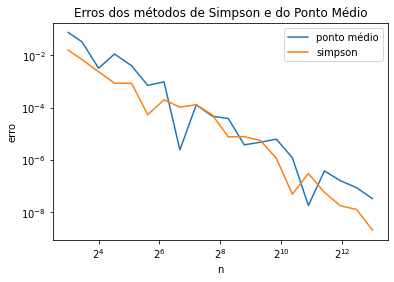

In [11]:
a, b = 0, 6
exact = F(b) - F(a)
ns = np.logspace(3,13, num=20, dtype=int, base=2)
err_m = []
err_s = []

for n in ns:
  err_m.append(abs(exact - midpoint(f, a, b, n)))
  err_s.append(abs(exact - simpson(f, a, b, n)))

ax = plt.gca()
ax.set_title("Erros dos métodos de Simpson e do Ponto Médio")
ax.loglog( ns, err_m, label="ponto médio")
ax.loglog( ns, err_s, label="simpson")
ax.set_xscale('log', basex=2)
plt.xlabel("n")
plt.ylabel("erro")
plt.legend()

In [12]:
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

In [13]:
for l in ax.lines:
    assert 1e-10 < min(l.get_ydata()) < 1e-7

In [14]:
ax = None

Como esse gráfico é diferente do outro?

Enquanto no primeiro gráfico, com intervalo $[0,3]$,  o comportamento é pratimente linear dentro de uma escala logaritmica. No segundo gráfico, para o intervalo de $[0,6]$,  o comportamento é oscilante dentro da escala logaritmica de acordo com o crescimento de $n$, sendo que o erro diminui na mesma proporção em ambos os métodos. Além disso, é possível perceber que a ordem de grandeza do erro aumentou para o intervalo maior, o que pode ser causado tanto pelo aumento de $h$, já que mantemos o mesmo número de subintervalos $n$ em um intervalo maior, como pela inclusão de um ponto onde a derivada não existe $x=\pi$.

## Questão 3: Encontrando o intervalo contendo $\pi$

Como $|\sin(x)|$ não é derivável em $\pi$, vamos ver quanto erro tem no sub-intervalo que "atravessa" $\pi$.

Escreva a função `I_x(a, b, x, n)` que retorna o intervalo contendo $x$ ao dividir $[a,b]$ em $n$ partes.
Você pode assumir que x nunca vai ser uma das extremidades $a_k$.

In [15]:
def I_x(a, b, x, n):
    """The interval  [xi, xi+h]  containing  x, when  [a,b]  is divided in  n  equal parts.
    Returns  None  if  x  is outside  [a,b]"""
    if (x-a)*(x-b) > 0:
        return
    pts = np.linspace(a,b, num = n+1 , endpoint=True)
    for i in range(len(pts)-1):
      if x < pts[i+1]:
        return pts[i], pts[i+1]

In [16]:
l, r = I_x(0, 6, np.pi, 10)
assert np.isclose(l, 3)
assert np.isclose(r, 3.6)

In [17]:
l, r = I_x(0, 60, np.pi, 10)
assert l <= np.pi <= r

In [18]:
l, r = I_x(0, 1, 0.4, 36)
assert l < 0.4 < r

Agora, faça o gráfico do erro que os métodos do ponto médio e de Simpson
vão dar quando integrarem o intervalo contendo a "descontinuidade" $\pi$,
em função de $n$.

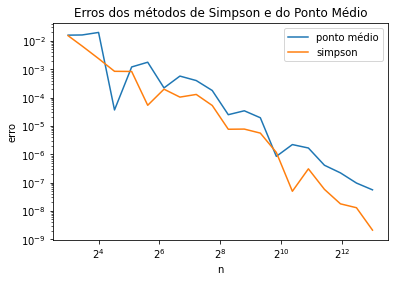

In [19]:
a, b = 0, 6
ns = np.logspace(3,13, num=20, dtype=int, base=2)
err_m = []
err_s = []
for n in ns:
  a_k, b_k = I_x(a,b, np.pi, n)
  exact = F(b_k) - F(a_k)
  err_m.append(abs(exact - midpoint(f, a_k, b_k, 1)))
  err_s.append(abs(exact - simpson(f, a_k, b_k, 1)))

ax = plt.gca()
ax.set_title("Erros dos métodos de Simpson e do Ponto Médio")
ax.loglog( ns, err_m, label="ponto médio")
ax.loglog( ns, err_s, label="simpson")
ax.set_xscale('log', basex=2)
plt.xlabel("n")
plt.ylabel("erro")
plt.legend()

In [20]:
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

In [21]:
for l in ax.lines:
    assert 1e-10 < min(l.get_ydata()) < 1e-7

In [22]:
ax = None

## Questão 4: Um intervalo contra todos

Vamos ver quanto do erro de cada método é causado pelo erro em apenas um intervalo.

Faça um gráfico para comparar esses erros:
- à esquerda, os erros para o ponto médio
- à direita, os erros para o método de Simpson

Text(0.5, 1.0, 'Erros no itervalo e subintervalo dos métodos de Simpson e do Ponto Médio')

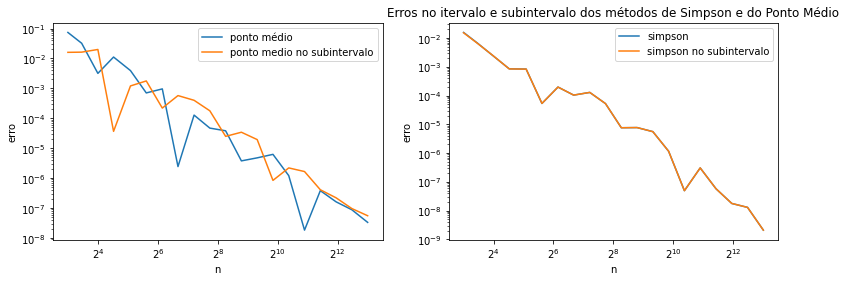

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,4))

a, b = 0, 6
exact = F(b) - F(a)
ns = np.logspace(3,13, num=20, dtype=int, base=2)
err_m = []
err_s = []
err_sub_m = []
err_sub_s = []

for n in ns:
  a_k, b_k = I_x(a,b, np.pi, n)
  exact_sub = F(b_k) - F(a_k)
  err_sub_m.append(abs(exact_sub - midpoint(f, a_k, b_k, 1)))
  err_sub_s.append(abs(exact_sub - simpson(f, a_k, b_k, 1)))
  err_m.append(abs(exact - midpoint(f, a, b, n)))
  err_s.append(abs(exact - simpson(f, a, b, n)))

ax1.loglog( ns, err_m, label="ponto médio")
ax1.loglog( ns, err_sub_m, label="ponto medio no subintervalo")
ax1.set_xscale('log', basex=2)
ax1.set_xlabel("n")
ax1.set_ylabel("erro")
ax1.legend()

ax2.loglog( ns, err_s, label="simpson")
ax2.loglog( ns, err_sub_s, label="simpson no subintervalo")
ax2.set_xscale('log', basex=2)
ax2.set_xlabel("n")
ax2.set_ylabel("erro")
ax2.legend()

ax = plt.gca()
ax.set_title("Erros no itervalo e subintervalo dos métodos de Simpson e do Ponto Médio")


In [24]:
assert len(ax1.lines) == 2
assert len(ax1.legend().texts) == 2

In [25]:
assert len(ax2.lines) == 2
assert len(ax2.legend().texts) == 2

In [26]:
for l in ax1.lines:
    assert 1e-10 < min(l.get_ydata()) < 1e-7
for l in ax2.lines:
    assert 1e-10 < min(l.get_ydata()) < 1e-7

In [27]:
ax = None

O que você observa quanto aos erros dos métodos?

É possivel observar que no método do ponto médio, o erro no subintervalo que contem $x= \pi$ em alguns momentos é maior que o erro no intervalo total e em outros é menor. Para que o módulo do erro total seja menor que o módulo do erro de um intervalo menor contendo $\pi$, pode ser que o erro nesse intervalo apresente um sinal oposto ao resto da integral, o que justifica que o erro no subintervalo seja maior em módulo que o erro total. 

Enquanto no método de simpson, o erro total é igual ao erro no subintervalo que contem $\pi$ (temos um gráfico em cima do outro), o que significa que o erro total do método se concentra na aplicação do método nesse intervalo.

## Questão 5: Integração com ajuda humana

Mude a integral de $[0,6]$ por duas integrais, uma em $[0,\pi]$ e outra em $[\pi,6]$.
Faça dois gráficos comparando os erros dos 4 métodos:
- Um para o método do ponto médio, o outro para o método de Simpson
- Em cada um, o erro cometido por uma única integral e o erro cometido pela integral feita em 2 partes

Use o mesmo número $n$ **total** de sub-intervalos, para não "roubar" em favor do que quebra a integral em 2  :-)

Text(0.5, 1.0, 'Erros no itervalo e subintervalo dos métodos de Simpson e do Ponto Médio')

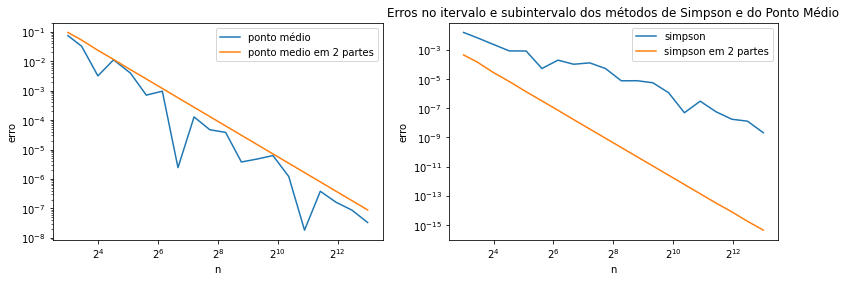

In [28]:
a, c, b = 0, np.pi, 6
exact = F(b) - F(a)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,4))
ns = np.logspace(3,13, num=20, dtype=int, base=2)
err_m = []
err_s = []
err_sub_m = []
err_sub_s = []

for n in ns:
  q, r = divmod(n, 2)
  n_1, n_2 = q, q
  if r != 0:
    n_2 = q+1
  err_m.append(abs(exact - midpoint(f, a, b, n)))
  err_sub_m.append(abs(exact - (midpoint(f, a, c, n_1) + midpoint(f, c, b, n_2))))
  
  err_s.append(abs(exact - simpson(f, a, b, n)))
  err_sub_s.append(abs(exact - (simpson(f, a, c, n_1) + simpson(f, c, b, n_2))))

ax1.loglog( ns, err_m, label="ponto médio")
ax1.loglog( ns, err_sub_m, label="ponto medio em 2 partes")
ax1.set_xscale('log', basex=2)
ax1.set_xlabel("n")
ax1.set_ylabel("erro")
ax1.legend()

ax2.loglog( ns, err_s, label="simpson")
ax2.loglog( ns, err_sub_s, label="simpson em 2 partes")
ax2.set_xscale('log', basex=2)
ax2.set_xlabel("n")
ax2.set_ylabel("erro")
ax2.legend()

ax = plt.gca()
ax.set_title("Erros no itervalo e subintervalo dos métodos de Simpson e do Ponto Médio")


In [29]:
assert len(ax1.lines) == 2
assert len(ax1.legend().texts) == 2
assert ax1.get_title != ""

In [30]:
assert len(ax2.lines) == 2
assert len(ax2.legend().texts) == 2
assert ax2.get_title != ""

In [31]:
ax = None

O que você observa?
O que você conclui?

É possível observar pelo segundo gráfico que ao integrar em duas partes, o erro no método de simpson diminui, enquanto no método do ponto médio, a integração em duas partes faz com que o erro aumente. O gráfico da integração em duas partes voltou a decair linearmente dentro de uma escala logaritimica (sem oscilações) para ambos os métodos, o que fortalece a hipótese de que as oscilações se devem ao intervalo que contém $\pi$, que sem uma aproximação por polinomios de Taylor válida (derivada nesse ponto não existe) gera uma inconsistência na variação do erro de acordo com $n$, pois o sinal do erro nesse intervalo pode ser oposto ao erro total. 

Por outro lado, o método do ponto médio utiliza apenas um único ponto enquanto o método de simpson considera mais de um ponto na interpolação de polinômios de Taylor em cada subintervalo. Com isso, os erros no método do ponto médio se apresentam maiores dependendo do ponto escolhido, já que como explicado acima, caso o intervalo contenha $\pi$ o decaimento do erro se torna oscilatorio, mas caso não contenha, o erro é sempre maior. 